# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1330s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1616, 32, 20, 3)
(1616, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
404/404 [==============================] - 6s 14ms/step - loss: 2.2178 - accuracy: 0.2890
Epoch 2/500
404/404 [==============================] - 6s 14ms/step - loss: 1.1752 - accuracy: 0.6318
Epoch 3/500
404/404 [==============================] - 6s 14ms/step - loss: 0.8169 - accuracy: 0.7461
Epoch 4/500
404/404 [==============================] - 5s 13ms/step - loss: 0.6419 - accuracy: 0.8166
Epoch 5/500
404/404 [==============================] - 6s 15ms/step - loss: 0.6047 - accuracy: 0.8049 1s - loss: 0.6 - ETA: 0s - loss: 0.608
Epoch 6/500
404/404 [==============================] - 6s 14ms/step - loss: 0.4364 - accuracy: 0.8624
Epoch 7/500
404/404 [==============================] - 6s 15ms/step - loss: 0.4540 - accuracy: 0.8613
Epoch 8/500
404/404 [==============================] - 6s 14ms/step - loss: 0.3497 - accuracy: 0.8970
Epoch 9/500
404/404 [==============================] - 6s 14ms/step - loss: 0.3154 - accuracy: 0.9098
Epoch 10/500
404/404 [=====================

404/404 [==============================] - 5s 12ms/step - loss: 0.0568 - accuracy: 0.9887 0s - loss: 0.0561 
Epoch 79/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0596 - accuracy: 0.9865
Epoch 80/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0487 - accuracy: 0.9851
Epoch 81/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0309 - accuracy: 0.9934
Epoch 82/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0454 - accuracy: 0.9877
Epoch 83/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0263 - accuracy: 0.9929
Epoch 84/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0377 - accuracy: 0.9878
Epoch 85/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0617 - accuracy: 0.9796
Epoch 86/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0546 - accuracy: 0.9859
Epoch 87/500
404/404 [==============================] - 5s 12ms/ste

404/404 [==============================] - 5s 12ms/step - loss: 0.0312 - accuracy: 0.9919 0s -
Epoch 157/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0294 - accuracy: 0.9930
Epoch 158/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0223 - accuracy: 0.9922
Epoch 159/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0252 - accuracy: 0.9957
Epoch 160/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0346 - accuracy: 0.9914
Epoch 161/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0336 - accuracy: 0.9906
Epoch 162/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0299 - accuracy: 0.9931
Epoch 163/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0151 - accuracy: 0.9953
Epoch 164/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0428 - accuracy: 0.9898
Epoch 165/500
404/404 [==============================] - 5s 12ms/step - l

404/404 [==============================] - 5s 13ms/step - loss: 0.0088 - accuracy: 0.9981
Epoch 234/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0122 - accuracy: 0.9956
Epoch 235/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0115 - accuracy: 0.9971
Epoch 236/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0177 - accuracy: 0.9964
Epoch 237/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0221 - accuracy: 0.9944
Epoch 238/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0218 - accuracy: 0.9946
Epoch 239/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0049 - accuracy: 0.9982 0s - loss: 0.0040 - ac
Epoch 240/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0133 - accuracy: 0.9963
Epoch 241/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0447 - accuracy: 0.9931 0s - loss: 0.0458 - accu
Epoch 242/500
404/404 [=======

404/404 [==============================] - 5s 13ms/step - loss: 0.0042 - accuracy: 0.9990 0s - loss: 0
Epoch 309/500
404/404 [==============================] - 6s 14ms/step - loss: 0.0102 - accuracy: 0.9971
Epoch 310/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0267 - accuracy: 0.9933
Epoch 311/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0222 - accuracy: 0.9883
Epoch 312/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0130 - accuracy: 0.9960
Epoch 313/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0178 - accuracy: 0.9960
Epoch 314/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0714 - accuracy: 0.9968
Epoch 315/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0225 - accuracy: 0.9951
Epoch 316/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0078 - accuracy: 0.9967
Epoch 317/500
404/404 [==============================] - 5s 14ms/

404/404 [==============================] - 5s 13ms/step - loss: 0.0056 - accuracy: 0.9974
Epoch 386/500
404/404 [==============================] - 6s 14ms/step - loss: 0.0022 - accuracy: 0.9996
Epoch 387/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0120 - accuracy: 0.9972
Epoch 388/500
404/404 [==============================] - 6s 14ms/step - loss: 0.0256 - accuracy: 0.9961
Epoch 389/500
404/404 [==============================] - 6s 14ms/step - loss: 0.0176 - accuracy: 0.9970
Epoch 390/500
404/404 [==============================] - 6s 14ms/step - loss: 0.0095 - accuracy: 0.9974
Epoch 391/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0180 - accuracy: 0.9976
Epoch 392/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0446 - accuracy: 0.9942
Epoch 393/500
404/404 [==============================] - 6s 14ms/step - loss: 0.0305 - accuracy: 0.9970
Epoch 394/500
404/404 [==============================] - 6s 14ms/step - loss: 

404/404 [==============================] - 4s 10ms/step - loss: 0.0032 - accuracy: 0.9996
Epoch 462/500
404/404 [==============================] - 5s 11ms/step - loss: 0.0062 - accuracy: 0.9964
Epoch 463/500
404/404 [==============================] - 4s 10ms/step - loss: 0.0045 - accuracy: 0.9988
Epoch 464/500
404/404 [==============================] - 4s 11ms/step - loss: 0.0045 - accuracy: 0.9978
Epoch 465/500
404/404 [==============================] - 4s 11ms/step - loss: 0.0038 - accuracy: 0.9977
Epoch 466/500
404/404 [==============================] - 5s 11ms/step - loss: 0.0057 - accuracy: 0.9982
Epoch 467/500
404/404 [==============================] - 4s 11ms/step - loss: 0.0058 - accuracy: 0.9976
Epoch 468/500
404/404 [==============================] - 4s 11ms/step - loss: 0.0239 - accuracy: 0.9938
Epoch 469/500
404/404 [==============================] - 5s 11ms/step - loss: 0.0086 - accuracy: 0.9973
Epoch 470/500
404/404 [==============================] - 5s 11ms/step - loss: 

### Learing result
 
* Visualization of the training and validation results

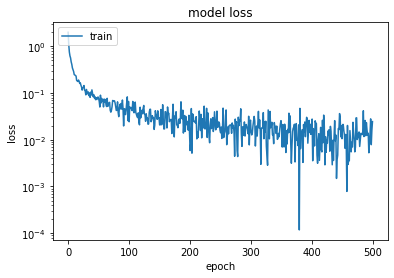

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\2_10_dig6_20210726-190157.jpg 2 -1


ziffer_sortiert_resize\2_10_dig6_20210727-130728.jpg 2 -1


ziffer_sortiert_resize\4_0_ht6_20210627-212552.jpg 4 1


ziffer_sortiert_resize\4_0_ht6_20210627-222846.jpg 4 1


ziffer_sortiert_resize\4_10_dig4_20210709-181251.jpg 4 -1


ziffer_sortiert_resize\4_10_ht6_20210628-105540.jpg 4 1


ziffer_sortiert_resize\5_3_dig4_20210721-144728.jpg 5 -1


ziffer_sortiert_resize\5_dig4_20210910-060143.jpg 5 9


ziffer_sortiert_resize\6_3_dig4_20210722-224727.jpg 6 -1


ziffer_sortiert_resize\7_10_dig6_20210727-150532.jpg 7 -1


ziffer_sortiert_resize\8_3_dig4_20210725-094630.jpg 8 -1


ziffer_sortiert_resize\8_3_dig6_20210716-214753.jpg 8 0


ziffer_sortiert_resize\9_3_dig4_20210726-214704.jpg 9 -1


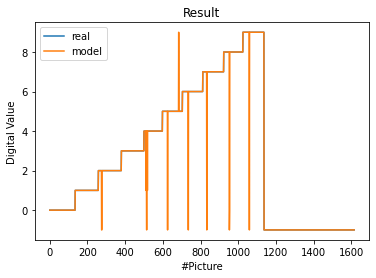

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp64qmmqi6\assets


766336

In [9]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp8l9k1dh8\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp8l9k1dh8\assets


dig1330s1q.tflite


203088

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.